In [1]:
# import the necessary libraries 
import numpy as np
import scipy as sp
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy.integrate import simps
import h5py

import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar 

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
fig_path = '/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/\
My Drive/Pauly Lab/Paper Submissions/Crossbeam/Unipolar Pressure/figures/'

### Data Upload

In [2]:
# uncomment below if downloading the data from your local machine
trxd_p = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/Pauly Lab/\
Paper Submissions/Crossbeam/Unipolar Pressure/data/tripulse.mat', 'r')

# # uncomment below if downloading the data from the cloud
# !gdown -O tripulse 'https://drive.google.com/uc?id=1kZbXrFvQ9b35x0fuhzdIRv7nhnvaBzw-'
# trxd_p = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/Unipolar Pressure/code/tripulse', 'r')

In [3]:
# extract the pressure(x, t) from the data
p2 = trxd_p.get('sensor_data/p')[()] # is sonicating top to bottom
# rotate and flip p2 so that p1 sonicates left to right (orthogonal)
p1 = np.flip(np.rot90(p2, k=1, axes=(1, 2)), axis=1)  

### Inversion and Delay
In the paper we explained why signal from one of the transducers needs to be inverted relative to the other one, while they need to be delayed with half a period. Inversion step is straightforward as we simply multiply the signal by $-1$. However, given the complexities such as curvature of the wave, delaying by half a period does not result in an ideal output. Therefore, we will find the optimal delay through an iterative algorithm below. 

In [4]:
# Invert the pulse for one of the transducers
p2_inv = p2 * -1

In [5]:
# simulation parameters
Nx = 500
Ny = 500
dx = 0.1e-3    # m
dy = 0.1e-3    # m
Nt = 2358    
dt = 2.0e-8    # s
rho = 1000     # kg/m3
c = 1500       # m/s
f = 1.0e6      # Hz
amp = 1.0e6    # Pa
x = np.linspace(0, Nx * dx * 1e3, Nx)                       # mm
y = np.linspace(-Ny * dy * 1e3/ 2, Ny * dy * 1e3 / 2, Ny)   # mm


# compute the period in simulation timesteps
c = 1500       # m/s
T = 1 / f      # s
dt = 2.0*1e-8  # s
n = T / dt
rho = 1000     # kg/m3

print(f'number of simulation steps in one full period: {n}')

number of simulation steps in one full period: 50.0


Let's do a sanity check to make sure the transducers are in-fact oriented as we want them to be:

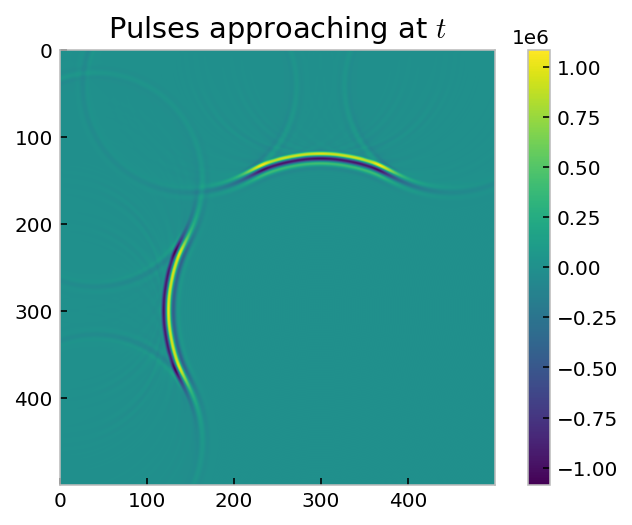

In [6]:
plt.title('Pulses approaching at $t$')
plt.imshow(p1[500] + p2_inv[500])
plt.grid(False)
plt.colorbar()
plt.show()

**Note** that in order to obtain maximum PPP/PNP, we need to delay trandsucer 1 and invert transducer 2 (as explained in the paper). However, in order to obtain maximum PNP/PPP, we need to both invert and delay transducer 2. 

In [26]:
def get_unipolar_pressure(p1, p2, num_cycles, start, end, target, peak_pressure):
    unipolar_pressure = []
    # compute the delay corresponding to dominant PPP
    if peak_pressure == 'ppp':
        for i in range(0, int(num_cycles * n) + 1):
            max_overlap = np.max(p1[start - i:end - i, target, target] + 
                                 p2_inv[start:end, target, target])
            min_overlap = abs(np.min(p1[start - i:end - i, target, target] + 
                                     p2_inv[start:end, target, target])) 
            if min_overlap == 0 or max_overlap == 0:
                continue
            unipolar_pressure.append(max_overlap / min_overlap)
    # compute the delay corresponding to dominant PNP            
    elif peak_pressure == 'pnp':
        for i in range(0, int(num_cycles * n) + 1):
            max_overlap = np.max(p1[start:end, target, target] + 
                                 p2_inv[start - i:end - i, target, target])
            min_overlap = abs(np.min(p1[start:end, target, target] + 
                                     p2_inv[start - i:end - i, target, target])) 
            if min_overlap == 0 or max_overlap == 0:
                continue
            unipolar_pressure.append(min_overlap / max_overlap)

    return unipolar_pressure

In [27]:
unipolar_pos = get_unipolar_pressure(p1, p2_inv, num_cycles=3, 
                                                   start=800, end=1200, 
                                                   target=299, peak_pressure='ppp')
unipolar_neg = get_unipolar_pressure(p1, p2_inv, num_cycles=3, 
                                                   start=800, end=1200, 
                                                   target=299, peak_pressure='pnp')

unipolar_pos = np.asarray(unipolar_pos)
unipolar_neg = np.asarray(unipolar_neg)

In [9]:
# optimal delays
delay_pos = np.argmax(unipolar_pos)  # for selective positive pressure
delay_neg = np.argmax(unipolar_neg)  # for selective negative pressure

In [10]:
print(f'we need to delay transducer 1 by {delay_pos} simulation time steps \n' + 
'and invert transducer 2, for maximum PPP/PNP')
print()
print(f'we need to invert and delay transducer 2 by {delay_neg} simulation time steps for maximum PNP/PPP')

we need to delay transducer 1 by 20 simulation time steps 
and invert transducer 2, for maximum PPP/PNP

we need to invert and delay transducer 2 by 20 simulation time steps for maximum PNP/PPP


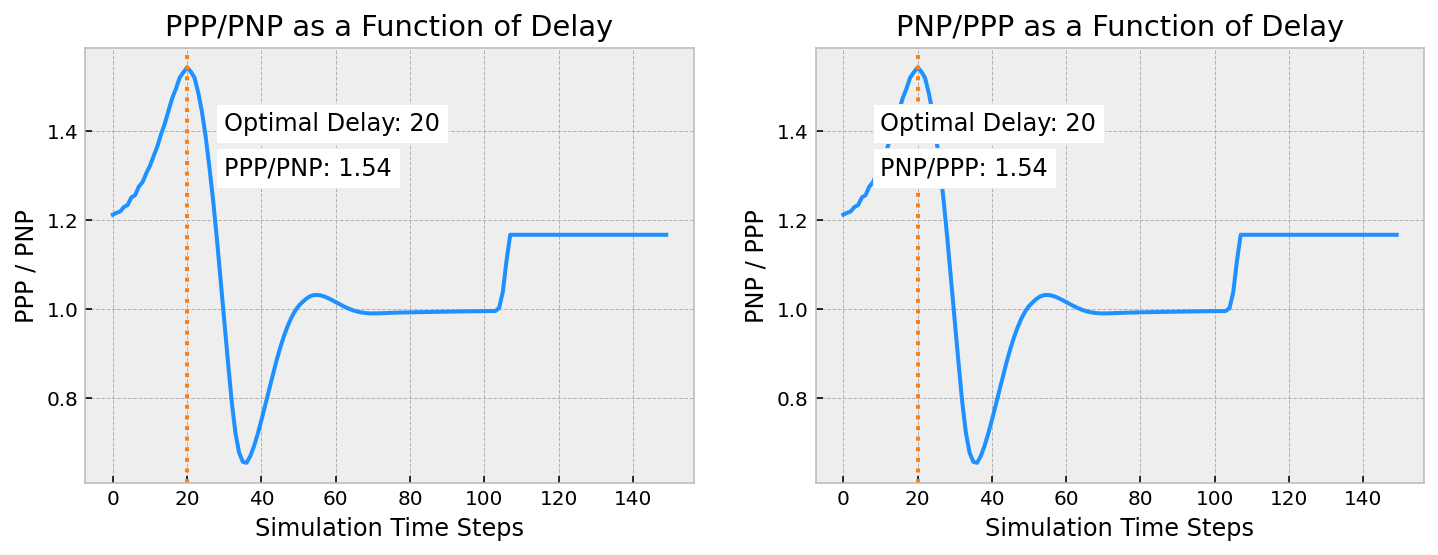

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('PPP/PNP as a Function of Delay')
plt.plot(unipolar_pos, color='dodgerblue')
plt.xlabel('Simulation Time Steps')
plt.ylabel('PPP / PNP')
plt.axvline(delay_pos, ls=':', c='tab:orange')
#plt.xlim(0, 50)
plt.text(30, 1.4, 'Optimal Delay: ' + str(delay_pos), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.text(30, 1.3, 'PPP/PNP: ' + str(np.round(unipolar_pos[delay_pos], 2)), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))

plt.subplot(1, 2, 2)
plt.title('PNP/PPP as a Function of Delay')
plt.plot(unipolar_neg, color='dodgerblue')
plt.xlabel('Simulation Time Steps')
plt.ylabel('PNP / PPP')
plt.axvline(delay_neg, ls=':', c='tab:orange')
#plt.xlim(0, 50)
plt.text(10, 1.4, 'Optimal Delay: ' + str(delay_neg), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.text(10, 1.3, 'PNP/PPP: ' + str(np.round(unipolar_neg[delay_neg], 2)), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.show()

In [12]:
target_ppp = []
target_pnp = []
for i in range(800, 1200):
    ppp = p1[i - delay_pos, 299, 299] +  p2_inv[i, 299, 299]
    pnp = p1[i, 299, 299] +  p2_inv[i - delay_neg, 299, 299]    
    target_ppp.append(ppp)
    target_pnp.append(pnp)    

In [13]:
target_ppp = np.asarray(target_ppp)
target_pnp = np.asarray(target_pnp)

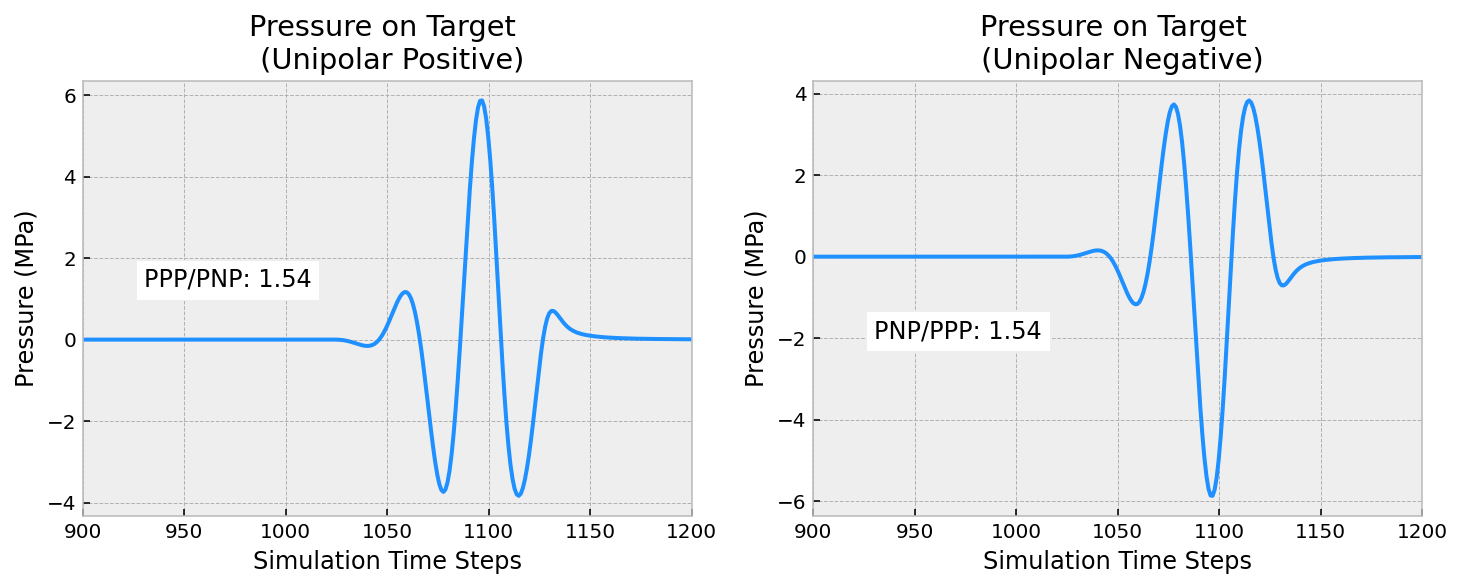

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Pressure on Target \n (Unipolar Positive)')
plt.plot(np.linspace(800, 1200, 400), target_ppp * 1e-6, color='dodgerblue')
plt.xlabel('Simulation Time Steps')
plt.ylabel('Pressure (MPa)')
plt.xlim(900, 1200)
plt.text(930, 1.3, 'PPP/PNP: ' + str(np.round(unipolar_pos[delay_pos], 2)), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))

plt.subplot(1, 2, 2)
plt.title('Pressure on Target \n (Unipolar Negative)')
plt.plot(np.linspace(800, 1200, 400), target_pnp * 1e-6, color='dodgerblue')
plt.xlabel('Simulation Time Steps')
plt.ylabel('Pressure (MPa)')
plt.xlim(900, 1200)
plt.text(930, -2, 'PNP/PPP: ' + str(np.round(unipolar_neg[delay_neg], 2)), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.show()

Since in the paper we mention Piezo2 ion channels that respond selectively to positive pressure, we will build the following figure for the paper:

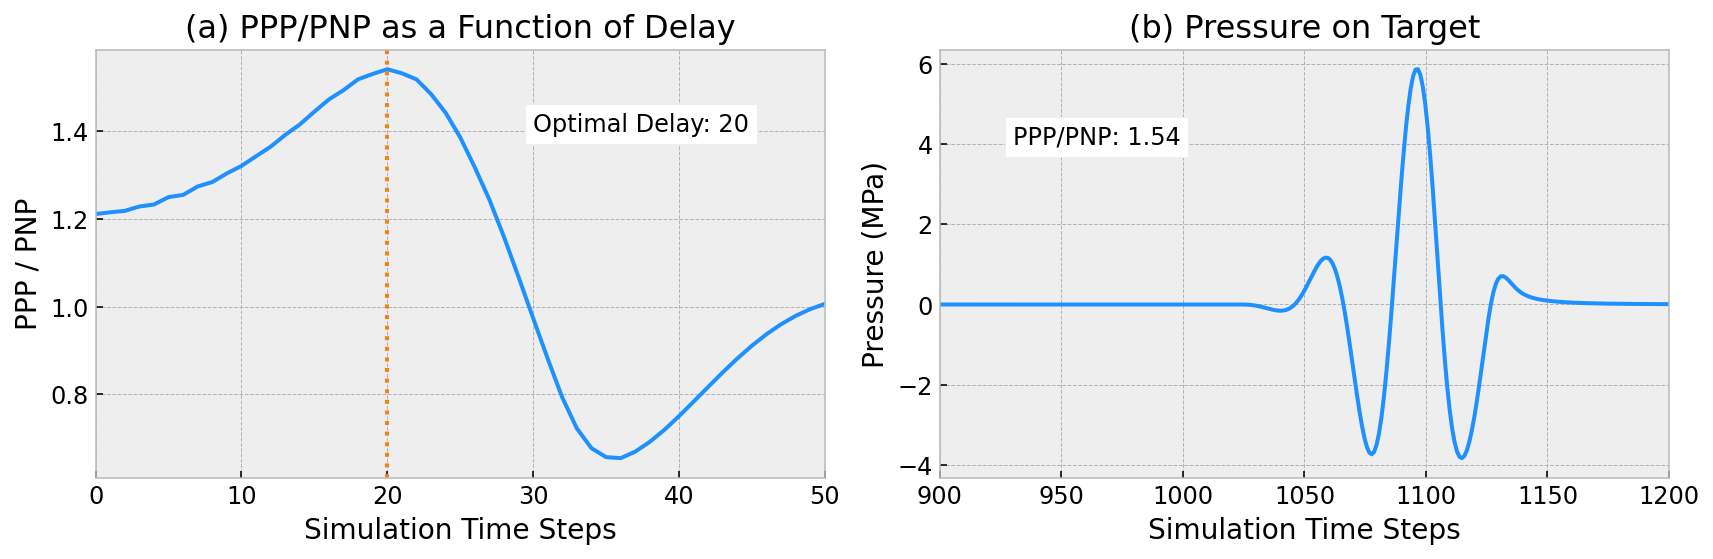

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('(a) PPP/PNP as a Function of Delay', fontsize=16)
plt.plot(unipolar_pos, color='dodgerblue')
plt.xlabel('Simulation Time Steps', fontsize=14)
plt.ylabel('PPP / PNP', fontsize=14)
plt.axvline(delay_pos, ls=':', c='tab:orange')
plt.xlim(0, 50)
plt.text(30, 1.4, 'Optimal Delay: ' + str(delay_pos), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
plt.title('(b) Pressure on Target', fontsize=16)
plt.plot(np.linspace(800, 1200, 400), target_ppp * 1e-6, color='dodgerblue')
plt.xlabel('Simulation Time Steps', fontsize=14)
plt.ylabel('Pressure (MPa)', fontsize=14)
plt.xlim(900, 1200)
plt.text(930, 4, 'PPP/PNP: ' + str(np.round(unipolar_pos[delay_pos], 2)), 
         fontsize=12, bbox=dict(facecolor='white', alpha=1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig(fig_path + 'PPP_over_PNP.png', dpi=600)
plt.show()

In [16]:
p_field_ppp = []
for i in range(800, 1200):
    p = p1[i - delay_pos, 250:350, 250:350] + p2_inv[i, 250:350, 250:350]
    p_field_ppp.append(np.max(p))

In [17]:
vmax = np.max(p_field_ppp)
vmin = - vmax

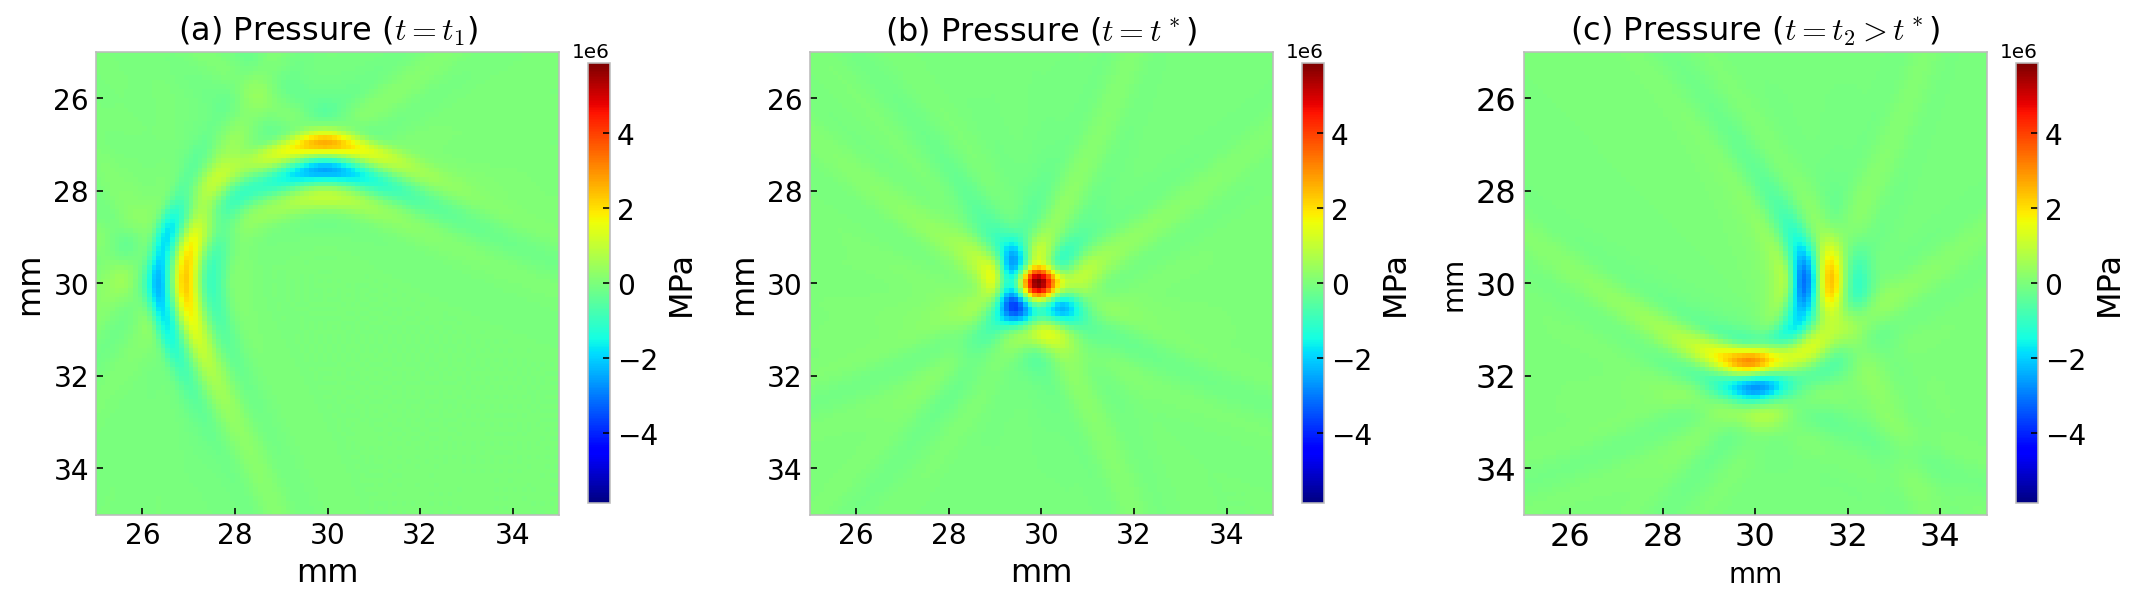

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) Pressure ($t=t_1$)', fontsize=16)
plt.imshow(p1[1000 - delay_pos, 250:350, 250:350] + p2_inv[1000, 250:350, 250:350], 
           cmap='jet', vmin=vmin, vmax=vmax, extent=(250*0.1, 350*0.1, 350*0.1, 250*0.1))
plt.ylabel('mm', fontsize=16)
plt.xlabel('mm', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(shrink=0.65)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='MPa', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) Pressure ($t=t^*$)', fontsize=16)
plt.imshow(p1[np.argmax(p_field_ppp) + 800 - delay_pos, 250:350, 250:350] + 
           p2_inv[np.argmax(p_field_ppp) + 800, 250:350, 250:350], 
           cmap='jet', vmin=vmin, vmax=vmax, extent=(250*0.1, 350*0.1, 350*0.1, 250*0.1))
plt.ylabel('mm', fontsize=16)
plt.xlabel('mm', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(shrink=0.65)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='MPa', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) Pressure ($t=t_2 > t^*$)', fontsize=16)
plt.imshow(p1[1150 - delay_pos, 250:350, 250:350] + 
           p2_inv[1150, 250:350, 250:350], cmap='jet', 
           vmin=vmin, vmax=vmax, extent=(250*0.1, 350*0.1, 350*0.1, 250*0.1))
plt.ylabel('mm', fontsize=14)
plt.xlabel('mm', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar(shrink=0.65)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='MPa', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(fig_path + 'unipolar_pressure_subplots.png', dpi=600)
plt.show()

### Analyze the Peak Pressure on Target

In [19]:
p_superposition = p1[np.argmax(p_field_ppp) + 800 - delay_pos, 250:350, 250:350] +\
p2_inv[np.argmax(p_field_ppp) + 800, 250:350, 250:350]

In [20]:
max65 = 0.65 * np.max(p_superposition)
max65_loc = np.where(p_superposition > max65)

max65_ymin, max65_ymax, max65_xmin, max65_xmax = (np.min(max65_loc[0]), 
                                                  np.max(max65_loc[0]), 
                                                  np.min(max65_loc[1]), 
                                                  np.max(max65_loc[1]))

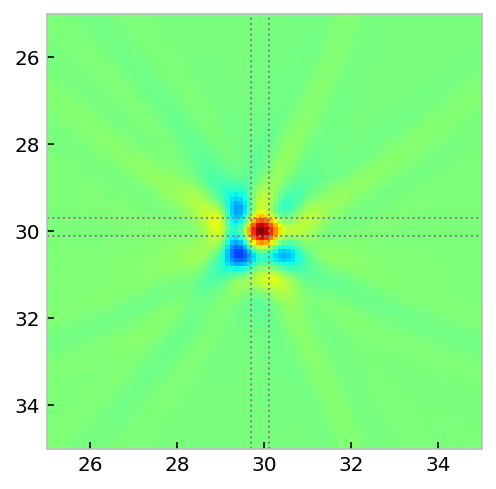

In [21]:
plt.imshow(p_superposition, cmap='jet', 
           extent=(250*0.1, 350*0.1, 350*0.1, 250*0.1), 
           vmin=vmin, vmax=vmax)
plt.axhline(25 + max65_ymin * dy * 1e3, lw=1, c='gray', ls=':')
plt.axhline(25 + max65_ymax * dy * 1e3, lw=1, c='gray', ls=':')
plt.axvline(25 + max65_xmin * dx * 1e3, lw=1, c='gray', ls=':')
plt.axvline(25 + max65_xmax * dx * 1e3, lw=1, c='gray', ls=':')
plt.grid(False)
plt.show()

In [22]:
print(f'FW65M along the x axis: {(max65_xmax - max65_xmin) * dx * 1e3} mm')
print(f'FW65M along the y axis: {(max65_ymax - max65_ymin) * dx * 1e3} mm')

FW65M along the x axis: 0.4 mm
FW65M along the y axis: 0.4 mm


In [23]:
print(f'wavelength per pulse: {(c * 1 / f * 1e3)} mm')

wavelength per pulse: 1.5 mm


Unipolar positive pressure covers a FW65%M area of $0.4\times 0.4 = 0.16 mm^2$. The wavelength at $1 MHz$ and $c=1500 m/s$ is expected to be $1.5 mm$.

In [24]:
# # uncomment the code below to run the animation
# fig = plt.figure(figsize=(6, 6))
  
# ims = []
# start_time = 800
# end_time = 1200
# for i in range(start_time, end_time, 1):
    
    
#     p_field = p1[i - delay_pos, 250:350, 250:350] + p2_inv[i, 250:350, 250:350]
#     target_p = p1[i - delay_pos, 299, 299] + p2_inv[i, 299, 299]
#     im = plt.imshow(p_field, cmap='jet')
#     text = plt.text(20, 20, str(np.round(target_p, 2)) + ' MPa')
    
#     plt.xlabel('mm')
#     plt.ylabel('mm')
#     plt.grid(False)
#     ims.append([im, text])

# ani = animation.ArtistAnimation(fig, ims, interval=1, blit=True,
#                                 repeat_delay=1)

# ani.save(fig_path + 'Unipolar.mp4', codec='mpeg4', fps=15, dpi=500)

# plt.show()